In [73]:
import numpy as np 
import matplotlib.pyplot as plt
import SynGenLoss_v2 as sgl  
from SynGenLoss_v2.Model1 import GenDataClass, GeneratorModel, CapabilityDiagram, SimpleCapDiag 
from SynGenLoss_v2.Model1.components.GenSaturationModel_v1 import SaturationModel
import gym 
from gym import spaces
import pandapower as pp 

# from load_model import PQLoadModel, PQ_model
from SC_create_grid import create_grid
from gen_data_config import G1, G2, G3, G4, G5

from environment_v1 import Env_v1 
# from environment_v2 import Env_v2 
from environment_hyperparams import Env_v1 as Env_h

import stable_baselines3 as sb3 
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy 
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

import warnings
warnings.filterwarnings("ignore")

In [2]:
from stable_baselines3.common.env_checker import check_env
env = Env_h()
check_env(env) 

In [43]:
env = Monitor(Env_h())

checkpoint_callback = CheckpointCallback(
  save_freq=100,
  save_path="RL_folder//initial_model//",
  name_prefix="rl_model_v1",
)

eval_callback = EvalCallback(env, best_model_save_path="RL_folder//initial_model//best_models",
                             log_path="RL_folder//initial_model//", eval_freq=100, n_eval_episodes=10,
                             deterministic=True, render=False)


# policy_kwargs = dict(net_arch=[dict(pi=[32], vf=[32])])
# model = PPO("MlpPolicy", env, verbose=0, n_steps=50, n_epochs=10, batch_size=32, policy_kwargs=policy_kwargs, learning_rate=0.001) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
policy_kwargs = dict(net_arch=dict(qf=[400, 300], pi=[64, 64]))
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0, gamma=0.9, policy_kwargs=policy_kwargs)
# model = A2C("MlpPolicy", env, verbose=0, n_steps=10, policy_kwargs=policy_kwargs)
model = model.learn(1000, callback=[checkpoint_callback, eval_callback])
plt.plot(env.get_episode_rewards()) 
plt.show() 

Eval num_timesteps=100, episode_reward=-66.39 +/- 11.11
Episode length: 5.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200, episode_reward=-32.36 +/- 7.65
Episode length: 5.00 +/- 0.00
New best mean reward!


KeyboardInterrupt: 

calc_reward -> 465 us <br> 
sanity_check -> 3.4 us <br> 
change_net -> 133 us <br> 
get_obs -> 14 ms <br> 
get_Q_lims -> 4 ms <br> 
runpp -> 9.2 ms 


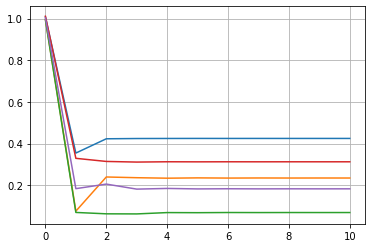

In [3]:
env = Env_h() 
obs = env.reset() 
V_gs = [obs[5:10]]
done = False
while not done:
    action, _ = model.predict([obs], deterministic=True)
    obs, rew, done, info = env.step(action[0])
    V_gs.append(obs[5:10])

V_gs = np.array(V_gs) 
plt.plot(V_gs)
plt.grid() 
plt.show() 

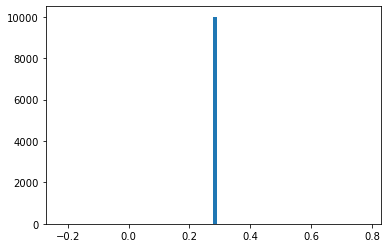

In [7]:
env = Env_h() 
obs = env.reset() 
obs = np.array([obs for i in range(10000)])
actions = []
actions, _ = model.predict(obs, deterministic=False)

plt.hist(actions[:, 0], bins=100)
plt.show() 

In [61]:
# Hyperparameters: 
N_train_steps = 10000  
N_retry = 3
N_eval_eps = 100
batch_sizes = [100, 1000]
NN_sizes = [([64, 64], [64, 64]), ([512, 512], [64, 64]), ([512, 512], [512, 512])]
taus = [0.005, 0.05]

gamma=0.99

env = Env_v1()
env_eval = Env_h()
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

rewards = np.zeros((len(batch_sizes)*len(NN_sizes)*len(taus), N_retry))
stds = np.zeros((len(batch_sizes)*len(NN_sizes)*len(taus), N_retry))

for i1, batch_size in enumerate(batch_sizes): 
    for i2, (NN_qf, NN_pi) in enumerate(NN_sizes): 
        for i3, tau in enumerate(taus): 
            idx = i1*(len(NN_sizes)*len(taus)) + i2*len(taus) + i3
            for i in range(N_retry):
                policy_kwargs = dict(net_arch=dict(qf=NN_qf, pi=NN_pi))
                model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0, gamma=gamma, policy_kwargs=policy_kwargs, batch_size=batch_size, tau=tau)
                model.learn(N_train_steps)
                rew, std = evaluate_policy(model, env_eval, N_eval_eps)
                rewards[idx, i] = rew 
                stds[idx, i] = std 
                
            res_str = f"batch_size = {batch_size}, NN_qf = {NN_qf}, NN_pi = {NN_pi}, tau = {tau}, eval_reward = {rewards[idx, i].mean():.3f}, eval_std = {stds[idx, i].mean():.3f}"
            print(res_str)


batch_size = 100, NN_qf = [64, 64], NN_pi = [64, 64], tau = 0.005, eval_reward = -6.110, eval_std = 1.919
batch_size = 100, NN_qf = [64, 64], NN_pi = [64, 64], tau = 0.05, eval_reward = -16.056, eval_std = 3.216
batch_size = 100, NN_qf = [512, 512], NN_pi = [64, 64], tau = 0.005, eval_reward = -5.067, eval_std = 1.644
batch_size = 100, NN_qf = [512, 512], NN_pi = [64, 64], tau = 0.05, eval_reward = -7.299, eval_std = 1.349
batch_size = 100, NN_qf = [512, 512], NN_pi = [512, 512], tau = 0.005, eval_reward = -4.940, eval_std = 1.411
batch_size = 100, NN_qf = [512, 512], NN_pi = [512, 512], tau = 0.05, eval_reward = -7.022, eval_std = 2.935
batch_size = 1000, NN_qf = [64, 64], NN_pi = [64, 64], tau = 0.005, eval_reward = -5.590, eval_std = 1.750
batch_size = 1000, NN_qf = [64, 64], NN_pi = [64, 64], tau = 0.05, eval_reward = -7.179, eval_std = 2.279
batch_size = 1000, NN_qf = [512, 512], NN_pi = [64, 64], tau = 0.005, eval_reward = -5.508, eval_std = 1.512
batch_size = 1000, NN_qf = [512,

In [62]:
save_name_rew = "RL_folder//hyperparam_search//rewards.npy"
save_name_std = "RL_folder//hyperparam_search//stds.npy"
np.save(save_name_rew, rewards)
np.save(save_name_std, stds)

In [70]:
rewards

array([[ -7.15800017,  -6.53552066,  -6.11039246],
       [-12.54868219, -16.89802836, -16.05599555],
       [ -6.23576663,  -5.88979915,  -5.06707806],
       [ -6.96256576,  -6.13670031,  -7.29895318],
       [ -5.3777205 ,  -4.85602756,  -4.94016135],
       [ -5.26172078,  -6.11595776,  -7.02175459],
       [ -7.54771425,  -7.31750591,  -5.59029169],
       [ -8.81373792,  -8.25266809,  -7.1785474 ],
       [ -5.40689844,  -5.30162417,  -5.50752735],
       [ -4.87475185,  -5.37342359,  -6.63847075],
       [ -6.39079781,  -6.04059424,  -7.07309492],
       [ -7.74829525,  -8.32254288,  -6.41956781]])

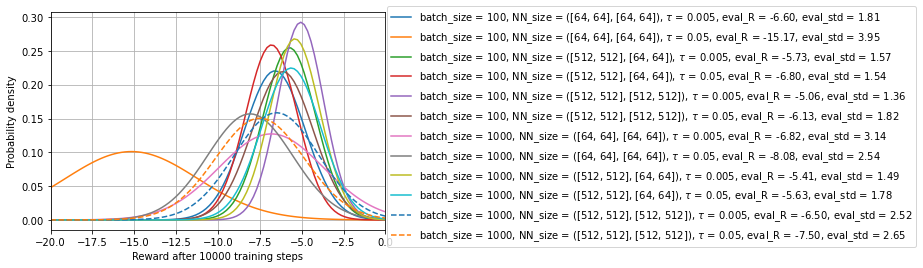

In [72]:
from scipy.stats import norm 

fig, ax = plt.subplots(1, 1)
labels = []
for i1, batch_size in enumerate(batch_sizes): 
    for i2, (NN_qf, NN_pi) in enumerate(NN_sizes): 
        for i3, tau in enumerate(taus): 
            idx = i1*(len(NN_sizes)*len(taus)) + i2*len(taus) + i3
            res_str = f"batch_size = {batch_size}, NN_size = ({NN_qf}, {NN_pi}), $\\tau$ = {tau}, eval_R = {rewards.mean(axis=1)[idx]:.2f}, eval_std = {stds.mean(axis=1)[idx]:.2f}"
            labels.append(res_str)

linestyles = ["solid"]*10 + ["dashed"]*2
rew_vals = np.linspace(-20, 0, 100)
for mean, std, label, ls in zip(rewards.mean(axis=1), stds.mean(axis=1), labels, linestyles): 
    vals = norm(mean, std).pdf(rew_vals)
    ax.plot(rew_vals, vals, label=label, linestyle=ls) 
    

ax.grid() 
ax.set_xlim(rew_vals[0], rew_vals[-1])
ax.legend(loc='upper right', bbox_to_anchor=(2.1, 0.55, 0.5, 0.5))     
ax.set_xlabel("Reward after 10000 training steps")
ax.set_ylabel("Probability density")
plt.savefig("figures/hyperparam_tuning.pdf", dpi=300, format="pdf", bbox_inches='tight')
plt.show() 

In [74]:
env = Monitor(Env_v1())
env_eval = Env_h()

checkpoint_callback = CheckpointCallback(
  save_freq=1000,
  save_path="RL_folder//final_training//",
  name_prefix="model_1",
)

eval_callback = EvalCallback(env_eval, best_model_save_path="RL_folder//final_training//best_models//model_1//",
                             log_path="RL_folder//final_training//", eval_freq=1000, n_eval_episodes=100,
                             deterministic=True, render=False)

policy_kwargs = dict(net_arch=dict(qf=[512, 512], pi=[64, 64]))
tau = 0.005
batch_size = 100

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
action_noise = OrnsteinUhlenbeckActionNoise(np.zeros(n_actions), 0.1 * np.ones(n_actions))
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0, policy_kwargs=policy_kwargs, batch_size=batch_size, tau=tau)
model = model.learn(100_000, callback=[checkpoint_callback, eval_callback])

AttributeError: 'int' object has no attribute 'shape'